# 1. Initial setup

In [1]:
# Importing modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

for dirname, _, filenames in os.walk('./kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from pandas import Series
from sklearn import metrics 
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score 

%matplotlib inline

./kaggle/input/sf-dst-scoring\sample_submission.csv
./kaggle/input/sf-dst-scoring\test.csv
./kaggle/input/sf-dst-scoring\train.csv


In [2]:
#Setting the conditions for experiments.
random_seed = 42
pd.set_option('display.max_columns', None)
data_directory = './kaggle/input/sf-dst-scoring/'

In [3]:
# Defining a function for detecting outliers.
def outlier_detect(data, column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    lower_number = len(data[column<lower_range])
    upper_number = len(data[column>upper_range])
    print('Lower Range:', lower_range,
          'Upper Range:', upper_range,
          'Lower Outliers:', lower_number,
          'Upper Outliers:', upper_number, 
          sep='\n')

In [4]:
# Defining a function for visualization of confusion matrix.
def show_confusion_matrix(y_true, y_pred):
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Default', 'Non-Default']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [5]:
# Defining a function for visualization of metrics for logistic regression.
def all_metrics(y_true, y_pred, y_pred_prob):
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['Positive, P'] = [P,'default']
    dict_metric['Negative, N'] = [N,'non-default']
    dict_metric['True Positive, TP'] = [TP,'correctly identified default']
    dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
    dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
    dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Precision = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Recall = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Harmonical mean of Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC AUC Score']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
    display(temp_df)   

In [6]:
# Importing datasets.
data_train = pd.read_csv(data_directory+'train.csv')
data_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

In [7]:
# Checking the data.
data_train.info()
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [8]:
# Checking the data.
data_test.info()
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [9]:
# Merging the datasets.
data_train['sample'] = 1
data_test['sample'] = 0
data = data_train.append(data_test, sort=False).reset_index(drop=True)

# 2. Preliminary data examination & engineering


In [10]:
# Checking the data.
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


In [11]:
# Checking for missing values.
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
sample                  0
dtype: int64

In [12]:
# Checking the number of unique values.
data.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
sample                   2
dtype: int64

* app_date - date of request, time variable, requires processing.
* education - level of education, categorical variable, requires processing and missing values correction.
* sex - binary variable, requires processing.
* age - continuous variable, requires processing.
* car - car availability, binary variable, requires processing.
* car_type - foreign-made car availability, binary variable, requires processing.
* decline_app_cnt - number of rejected requests, continuous variable.
* good_work - flag of a well-paid job, binary variable.
* score_bki - BKI (credit reporting agency) internal score, continuous variable.
* bki_request_cnt - number of requests to the BKI (credit reporting agency), continuous variable.
* region_rating - rating of the region, categorical variable.
* home_address - home address categorizer, categorical variable.
* work_address - work address categorizer, categorical variable.
* income - client's income level, continuous variable. 
* sna - level of connection with another clients, categorical variable.
* first_time - how long the client has been in the database, categorical variable.
* foreign_passport - passport availability, binary variable, requires processing.
* default - default in the past, binary target variable.  

In [13]:
# Grouping column names by data type.
time_cols = ['app_date']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

In [14]:
# Checking the missing values.
data['education'].value_counts(dropna = False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

Let's create a new binary variable for missing values in the "education"column.

In [15]:
# Creating a new feature.
data['education_nan'] = pd.isna(data['education']).astype('uint8')

As a temporary measure, let's fill in the missing values with school education.

In [16]:
# Filling the missing values with the most frequent value ('SCH').
data['education'] = data['education'].fillna('SCH')

Let's convert binary variables to numeric format using LabelEncoder.

In [17]:
# Encoding binary variables.
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [18]:
# Checking the data.
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,education_nan
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,0
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,0
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,0
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,0
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,0


# 3. Analysis of variables

## 3.1 Application date (+new feature: timedelta)

In [19]:
# Converting the data to datetime.
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

Let's see what is the earliest request date in the dataset.

In [20]:
# Finding the minimum.
data_min = min(data['app_date'])

Now let's introduce a new variable - the difference between the request date and the minimum.

In [21]:
# Creating a new feature.
data['app_date_timedelta'] = (data['app_date'] - data_min).dt.days.astype('int')

Let's add our new feature to the list of continuous variables.

In [22]:
# Adding a feature to the list.
num_cols.append('app_date_timedelta')

<AxesSubplot:>

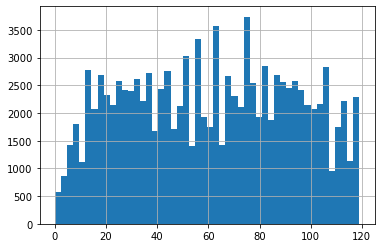

In [23]:
# Checking the frequency distribution.
data['app_date_timedelta'].hist(bins=50)

<AxesSubplot:>

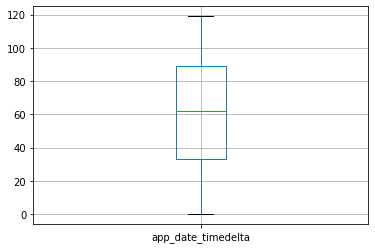

In [24]:
# Checking the frequency distribution.
data.boxplot(column=['app_date_timedelta'])

In [25]:
# Detection of outliers.
outlier_detect(data,data['app_date_timedelta'])

Lower Range:
-51.0
Upper Range:
173.0
Lower Outliers:
0
Upper Outliers:
0


## 3.2 Education

<AxesSubplot:>

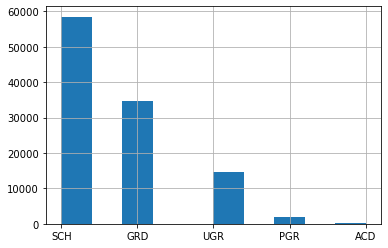

In [26]:
# Checking the frequency distribution.
data['education'].hist()

Everything looks logical: the higher the level of education, the fewer clients apply for a loan. Now let's convert education feature to numeric format using 'map' function.

In [27]:
# Encoding a categorical variable.
education_dict = {
    'SCH': 1,
    'GRD': 2,
    'UGR': 3,
    'PGR': 4,
    'ACD': 5,
}

data['education'] = data['education'].map(education_dict)

## 3.3 Gender

<AxesSubplot:>

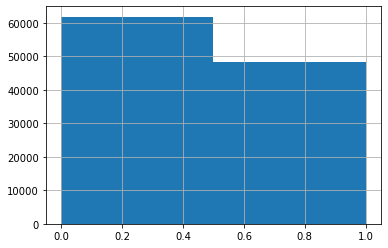

In [28]:
# Checking the frequency distribution.
data['sex'].hist(bins=2)

It seems that the bank has much more female clients.

## 3.4 Age

<AxesSubplot:>

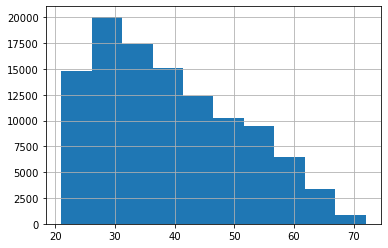

In [29]:
# Checking the frequency distribution.
data['age'].hist()

<AxesSubplot:>

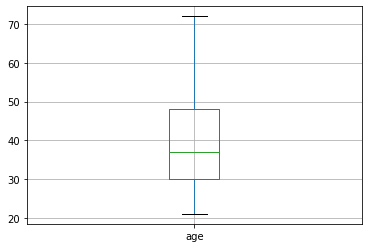

In [30]:
# Checking the frequency distribution.
data.boxplot(column=['age'])

In [31]:
# Detection of outliers.
outlier_detect(data,data['age'])

Lower Range:
3.0
Upper Range:
75.0
Lower Outliers:
0
Upper Outliers:
0


People in their mid-30s are more likely to make big purchases, so it seems logical that we have a maximum there. Now let's log the data and look at the distribution.

<AxesSubplot:>

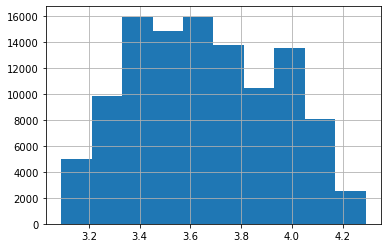

In [32]:
# Taking the logarithm.
np.log(data['age'] + 1).hist()

The distribution looks normal, so let's keep the logarithm.

In [33]:
# Taking the logarithm.
data['age'] = np.log(data['age'] + 1)
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,education_nan,app_date_timedelta
0,25905,2014-02-01,1,1,4.143135,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,0,31
1,63161,2014-03-12,1,0,4.094345,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,0,70
2,25887,2014-02-01,1,1,3.258097,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,0,31
3,16222,2014-01-23,1,0,3.988984,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,0,22
4,101655,2014-04-18,2,1,3.891820,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,0,107


<AxesSubplot:>

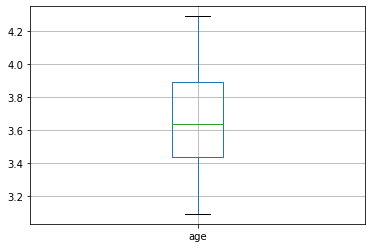

In [34]:
# Checking the frequency distribution.
data.boxplot(column=['age'])

In [35]:
# Detection of outliers.
outlier_detect(data,data['age'])

Lower Range:
2.7472375640469258
Upper Range:
4.5785699385488465
Lower Outliers:
0
Upper Outliers:
0


## 3.5 Car

<AxesSubplot:>

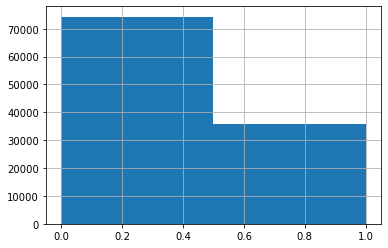

In [36]:
# Checking the frequency distribution.
data['car'].hist(bins=2)

Most of the clients in this dataset don't have a car.

## 3.6 Foreign-made car

<AxesSubplot:>

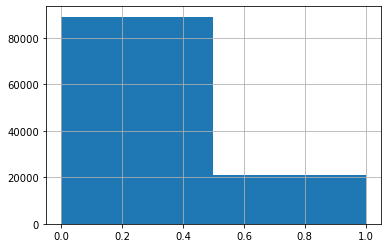

In [37]:
# Checking the frequency distribution.
data['car_type'].hist(bins=2)

Most car owners from this dataset have a car of domestic production.

## 3.7 Declined applications

<AxesSubplot:>

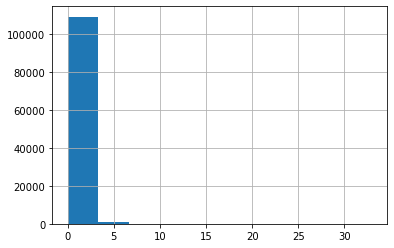

In [38]:
# Checking the frequency distribution.
data['decline_app_cnt'].hist()

<AxesSubplot:>

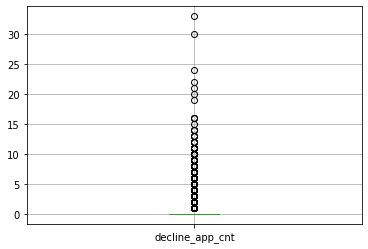

In [39]:
# Checking the frequency distribution.
data.boxplot(column=['decline_app_cnt'])

In [40]:
# Detection of outliers.
outlier_detect(data,data['decline_app_cnt'])

Lower Range:
0.0
Upper Range:
0.0
Lower Outliers:
0
Upper Outliers:
18677


The vast majority of borrowers do not have rejected applications, so our function treats a significant part of the results as outliers. Let's try to correct the situation by taking the logarithm of the column.

<AxesSubplot:>

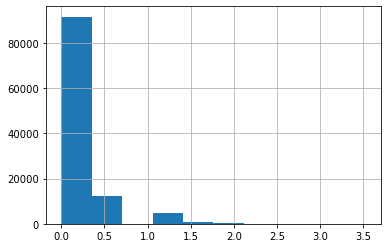

In [41]:
# Taking the logarithm.
np.log(data['decline_app_cnt'] + 1).hist()

In [42]:
# Taking the logarithm.
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)

<AxesSubplot:>

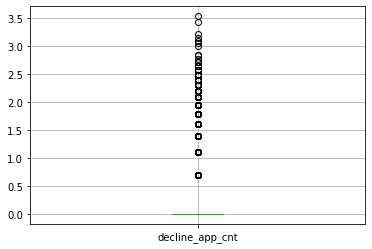

In [43]:
# Checking the frequency distribution.
data.boxplot(column=['decline_app_cnt'])

In [44]:
# Detection of outliers.
outlier_detect(data,data['decline_app_cnt'])

Lower Range:
0.0
Upper Range:
0.0
Lower Outliers:
0
Upper Outliers:
18677


Unfortunately, the situation has not changed for the better.

## 3.8 Good work (well-paid job)

<AxesSubplot:>

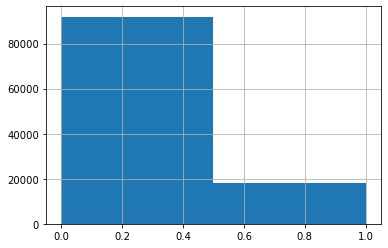

In [45]:
# Checking the frequency distribution.
data['good_work'].hist(bins=2)

Most of the clients in this dataset don't have a well-paid job.

## 3.9 BKI score

<AxesSubplot:>

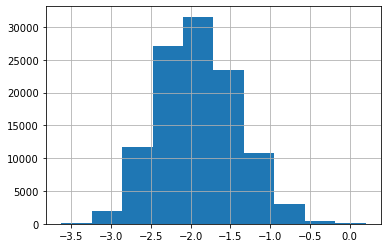

In [46]:
# Checking the frequency distribution.
data['score_bki'].hist()

<AxesSubplot:>

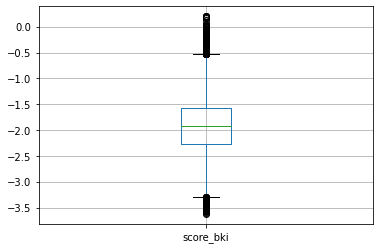

In [47]:
# Checking the frequency distribution.
data.boxplot(column=['score_bki'])

In [48]:
# Detection of outliers.
outlier_detect(data,data['score_bki'])

Lower Range:
-3.299251946250001
Upper Range:
-0.5290698762499992
Lower Outliers:
82
Upper Outliers:
436


The distribution looks normal, and there aren't many outliers.

## 3.10 BKI requests

<AxesSubplot:>

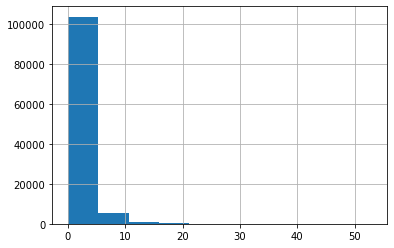

In [49]:
# Checking the frequency distribution.
data['bki_request_cnt'].hist()

<AxesSubplot:>

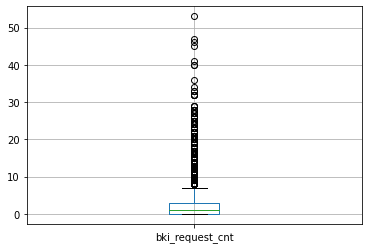

In [50]:
# Checking the frequency distribution.
data.boxplot(column=['bki_request_cnt'])

In [51]:
# Detection of outliers.
outlier_detect(data,data['bki_request_cnt'])

Lower Range:
-4.5
Upper Range:
7.5
Lower Outliers:
0
Upper Outliers:
2636


<AxesSubplot:>

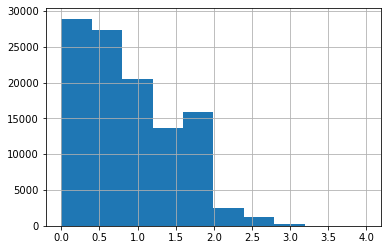

In [52]:
# Taking the logarithm.
np.log(data['bki_request_cnt'] + 1).hist()

In [53]:
# Taking the logarithm.
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)

<AxesSubplot:>

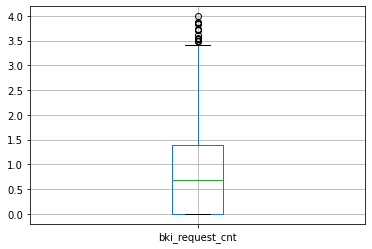

In [54]:
# Checking the frequency distribution.
data.boxplot(column=['bki_request_cnt'])

In [55]:
# Detection of outliers.
outlier_detect(data,data['bki_request_cnt'])

Lower Range:
-2.0794415416798357
Upper Range:
3.465735902799726
Lower Outliers:
0
Upper Outliers:
15


Logarithmization significantly improved the situation, the number of outliers was reduced from 2636 to 15.


## 3.11 Region rating

<AxesSubplot:>

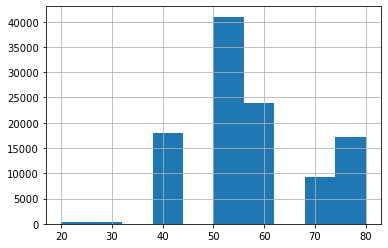

In [56]:
# Checking the frequency distribution.
data['region_rating'].hist()

## 3.12 Home address

<AxesSubplot:>

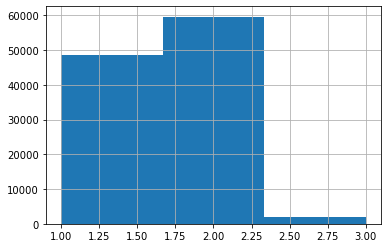

In [57]:
# Checking the frequency distribution.
data['home_address'].hist(bins=3)

## 3.13 Work address

<AxesSubplot:>

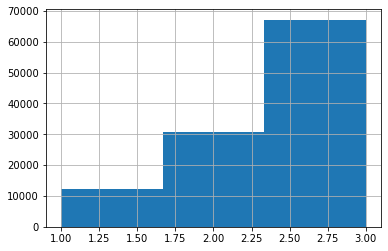

In [58]:
# Checking the frequency distribution.
data['work_address'].hist(bins=3)

## 3.14 Income

<AxesSubplot:>

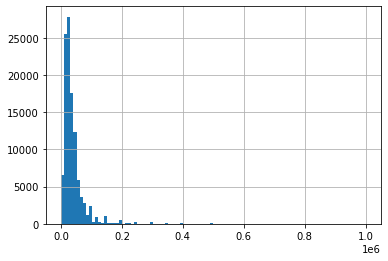

In [59]:
# Checking the frequency distribution.
data['income'].hist(bins=100)

<AxesSubplot:>

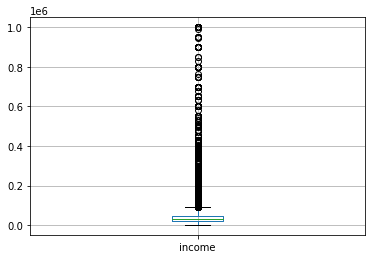

In [60]:
# Checking the frequency distribution.
data.boxplot(column=['income'])

In [61]:
# Checking the frequency distribution.
outlier_detect(data,data['income'])

Lower Range:
-22000.0
Upper Range:
90000.0
Lower Outliers:
0
Upper Outliers:
7000


<AxesSubplot:>

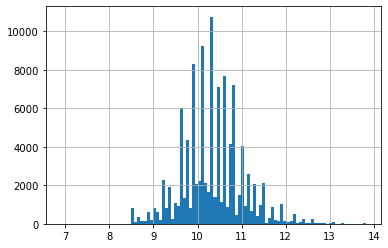

In [62]:
# Taking the logarithm.
np.log(data['income'] + 1).hist(bins=100)

In [63]:
# Taking the logarithm.
data['income'] = np.log(data['income'] + 1)

<AxesSubplot:>

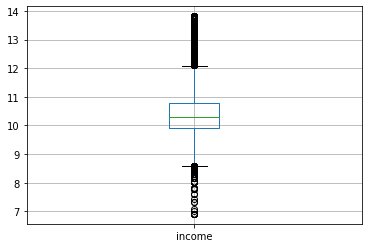

In [64]:
# Checking the frequency distribution.
data.boxplot(column=['income'])

In [65]:
# Detection of outliers.
outlier_detect(data,data['income'])

Lower Range:
8.590378193705899
Upper Range:
12.092136480586621
Lower Outliers:
875
Upper Outliers:
1734


Logarithmization improved the situation, the distribution changed from lognormal to normal, and the number of outliers decreased from 7000 to 2609.

## 3.15 SNA (level of connection with other clients)

<AxesSubplot:>

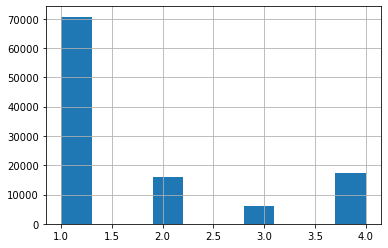

In [66]:
# Checking the frequency distribution.
data['sna'].hist()

## 3.16 First time (how long the client has been in the database)

<AxesSubplot:>

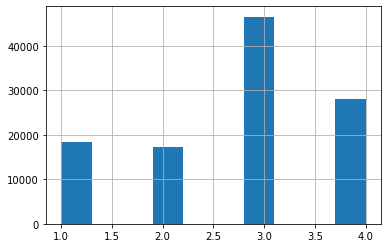

In [67]:
# Checking the frequency distribution.
data['first_time'].hist()

## 3.17 Foreign passport

<AxesSubplot:>

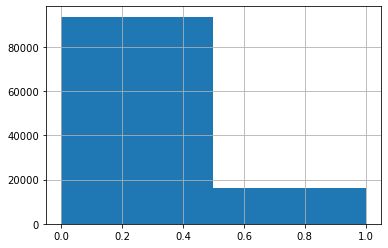

In [68]:
# Checking the frequency distribution.
data['foreign_passport'].hist(bins=2)

Most of the clients in this dataset don't have a foreign passport.

## 3.18 Default

<AxesSubplot:>

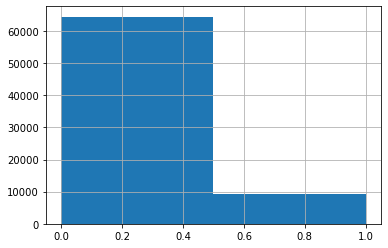

In [69]:
# Checking the frequency distribution.
data['default'].hist(bins=2)

The balance of classes in our dataset is strongly skewed towards customers who do not have a default.

# 4. Feature importance

<AxesSubplot:>

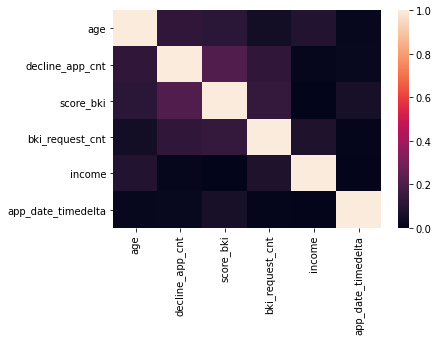

In [70]:
# Checking the correlation matrix
data_train_temp = data[data['sample']==1]
sns.heatmap(data_train_temp[num_cols].corr().abs(), vmin=0, vmax=1)

In [71]:
# Checking the correlation matrix
data_train_temp[num_cols].corr().abs().sort_values(by='decline_app_cnt', ascending=False)

,age,decline_app_cnt,score_bki,bki_request_cnt,income,app_date_timedelta
decline_app_cnt,0.127734,1.000000,0.210090,0.125163,0.013868,0.022662
score_bki,0.109971,0.210090,1.000000,0.139622,0.002860,0.063605
age,1.000000,0.127734,0.109971,0.049327,0.092586,0.017071
bki_request_cnt,0.049327,0.125163,0.139622,1.000000,0.081019,0.009758
app_date_timedelta,0.017071,0.022662,0.063605,0.009758,0.005197,1.000000
income,0.092586,0.013868,0.002860,0.081019,1.000000,0.005197


There were no strong correlations between the features, except for the number of declined applications and the BKI score. Unfortunately, I didn't have enough time to test the model with a different set of features.

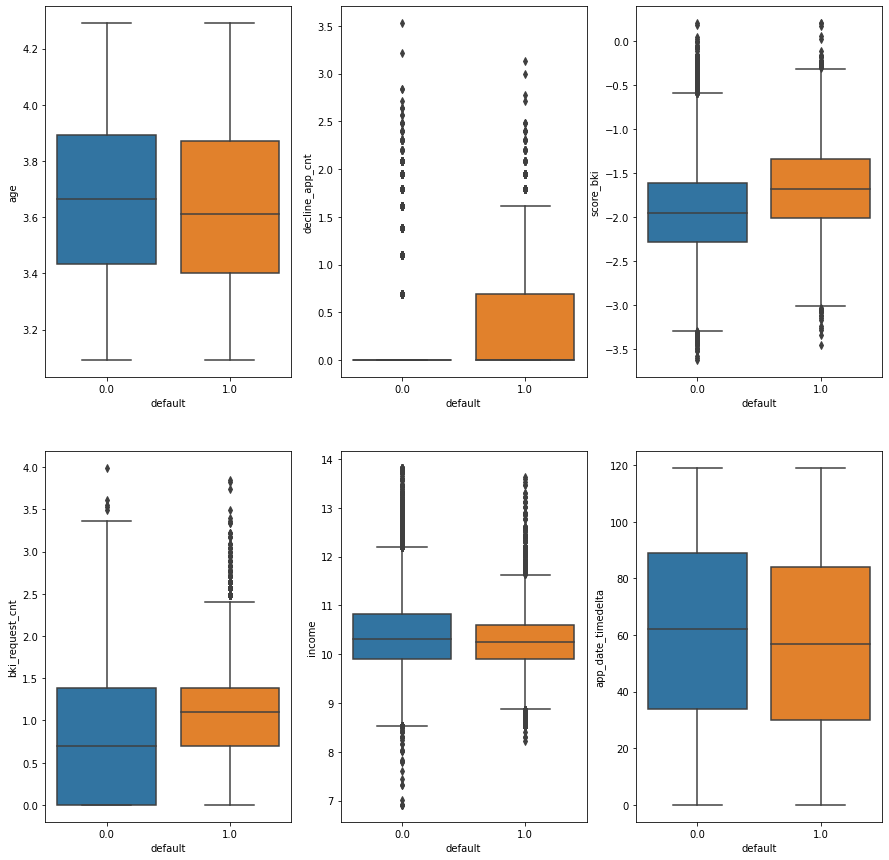

In [72]:
# Checking the frequency distribution.
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data_train_temp, ax=axes[i])

Default clients are on average younger and earn less, have more applications and rejections from the bank, but simultaneously they have a higher BKI rating.

<AxesSubplot:>

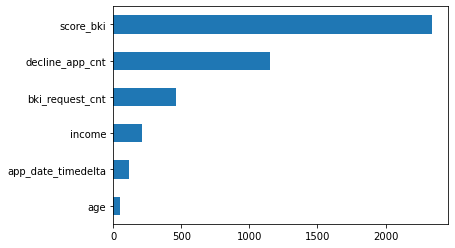

In [73]:
# Checking the importance of features.
imp_num = Series(f_classif(data_train_temp[num_cols], 
                           data_train_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

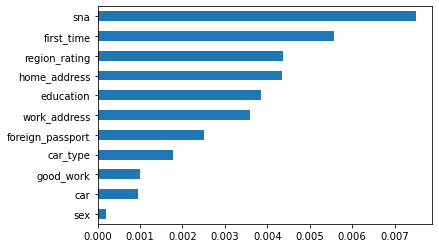

In [74]:
# Checking the importance of features.
imp_cat = Series(mutual_info_classif(
    data_train_temp[bin_cols + cat_cols], data_train_temp['default'], 
    discrete_features =True
), index = bin_cols + cat_cols)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Of the continuous variables, the most important are the number of declined applications and the BKI rating. Of the categorical and binary non-variables, the most important are connections with other clients and the time spent in the database.

# 5. Data preprocessing¶


## 5.1 Standardization

In [75]:
# Standardization of data.
ss = StandardScaler()
data[num_cols] = pd.DataFrame(ss.fit_transform(data[num_cols]),columns = data[num_cols].columns)

In [76]:
# Checking the data.
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   client_id           110148 non-null  int64         
 1   app_date            110148 non-null  datetime64[ns]
 2   education           110148 non-null  int64         
 3   sex                 110148 non-null  int32         
 4   age                 110148 non-null  float64       
 5   car                 110148 non-null  int32         
 6   car_type            110148 non-null  int32         
 7   decline_app_cnt     110148 non-null  float64       
 8   good_work           110148 non-null  int64         
 9   score_bki           110148 non-null  float64       
 10  bki_request_cnt     110148 non-null  float64       
 11  region_rating       110148 non-null  int64         
 12  home_address        110148 non-null  int64         
 13  work_address        110148 no

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,education_nan,app_date_timedelta
0,25905,2014-02-01,1,1,1.714029,1,1,-0.418815,0,-0.208688,-0.281790,50,1,2,-0.786080,4,1,0,0.0,1,0,-0.934391
1,63161,2014-03-12,1,0,1.542867,0,0,-0.418815,0,0.745419,0.770563,50,2,3,-0.708472,4,1,0,0.0,1,0,0.281474
2,25887,2014-02-01,1,1,-1.390791,1,0,2.621662,0,0.993988,-0.281790,80,1,2,-0.052834,1,4,1,0.0,1,0,-0.934391
3,16222,2014-01-23,1,0,1.173250,0,0,-0.418815,0,-0.306243,0.333797,50,2,3,-1.629771,1,3,0,0.0,1,0,-1.214975
4,101655,2014-04-18,2,1,0.832388,0,0,-0.418815,1,1.321223,-0.281790,60,2,3,-0.052834,1,4,1,0.0,1,0,1.434987


## 5.2 Using RandomForestRegressor to fill missing values in "education" feature

In [77]:
# Data processing and model training.
data_temp = data.drop(['sample', 'client_id', 'app_date', 'default'], axis=1)
data_education_nan = data_temp[data_temp['education_nan']==1]
data_no_nan = data_temp[data_temp['education_nan']==0]
y = data_no_nan['education'].values
X = data_no_nan.drop(['education'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_seed)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state = random_seed)
model.fit(X_train, y_train)
y_pred = np.round(model.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [78]:
# Predicting the values.
predict = np.round(model.predict(data_education_nan.drop(['education'], axis=1)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [79]:
# Adding predicted values to the dataset.
index_education_nan = data[data['education_nan']==1].index
data.loc[index_education_nan,'education'] = predict

## 5.3 One-hot encoding

In [80]:
# Encoding categorical variables.
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 42 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   client_id           110148 non-null  int64         
 1   app_date            110148 non-null  datetime64[ns]
 2   sex                 110148 non-null  int32         
 3   age                 110148 non-null  float64       
 4   car                 110148 non-null  int32         
 5   car_type            110148 non-null  int32         
 6   decline_app_cnt     110148 non-null  float64       
 7   good_work           110148 non-null  int64         
 8   score_bki           110148 non-null  float64       
 9   bki_request_cnt     110148 non-null  float64       
 10  income              110148 non-null  float64       
 11  foreign_passport    110148 non-null  int32         
 12  default             73799 non-null   float64       
 13  sample              110148 no

In [81]:
# Checking the data.
data.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,sample,education_nan,app_date_timedelta,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,2014-02-01,1,1.714029,1,1,-0.418815,0,-0.208688,-0.281790,-0.786080,0,0.0,1,0,-0.934391,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,1.542867,0,0,-0.418815,0,0.745419,0.770563,-0.708472,0,0.0,1,0,0.281474,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0
2,25887,2014-02-01,1,-1.390791,1,0,2.621662,0,0.993988,-0.281790,-0.052834,1,0.0,1,0,-0.934391,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1
3,16222,2014-01-23,0,1.173250,0,0,-0.418815,0,-0.306243,0.333797,-1.629771,0,0.0,1,0,-1.214975,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0
4,101655,2014-04-18,1,0.832388,0,0,-0.418815,1,1.321223,-0.281790,-0.052834,1,0.0,1,0,1.434987,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


# 6. Model

In [82]:
# Splitting the dataset.
data_train = data.query('sample == 1').drop(['sample', 'client_id', 'app_date'], axis=1)
data_test = data.query('sample == 0').drop(['sample', 'client_id', 'app_date'], axis=1)

In [83]:
# Training and predicting.
X = data_train.drop(['default'], axis=1)
y = data_train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

G:\Soft\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 7. Model evaluation

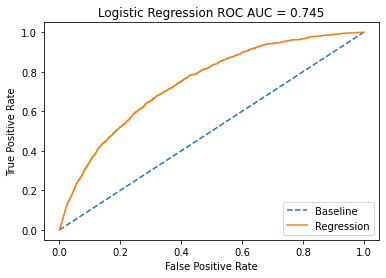

In [84]:
# Plotting the ROC curve
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

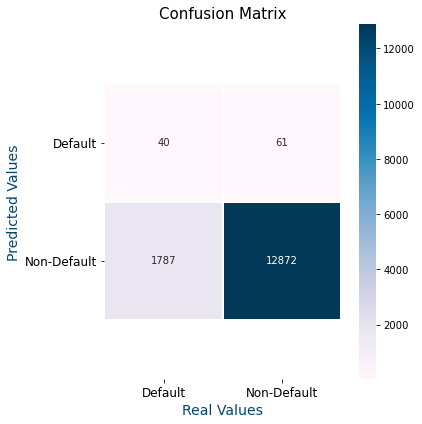

In [85]:
# Checking the confusion matrix.
show_confusion_matrix(y_test, y_pred)

In [86]:
# Checking the metrics.
all_metrics(y_test, y_pred, y_pred_prob)

,Value,Description
"Positive, P",1827.000000,default
"Negative, N",12933.000000,non-default
"True Positive, TP",40.000000,correctly identified default
"True Negative, TN",12872.000000,correctly identified non-default
"False Positive, FP",61.000000,incorrectly identified default
"False Negative, FN",1787.000000,incorrectly identified non-default
Accuracy,0.874797,Accuracy=(TP+TN)/(P+N)
Precision,0.396040,Precision = TP/(TP+FP)
Recall,0.021894,Recall = TP/P
F1-score,0.041494,Harmonical mean of Precision и Recall


The ROC AUC score is good, but the confusion matrix shows us that our model predicts defaults very poorly. Of the 1827 defaults, only 40 were correctly predicted, or about 2 percent (very low Recall). Let's try to improve the situation by using custom hyperparameters.

# 8. Regularization

In [87]:
model = LogisticRegression(random_state=random_seed)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6711
Precision: 0.2265
Recall: 0.6864
F1: 0.3406


We have identified optimal hyperparameters. Now let's train the model using these hyperparameters.

In [88]:
# Training and predicting.
model = LogisticRegression(random_state=random_seed, 
                           C=1, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l1', 
                           solver='liblinear', 
                           verbose=0, 
                           warm_start=False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

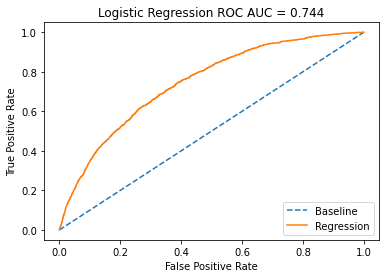

In [89]:
# Plotting the ROC curve
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

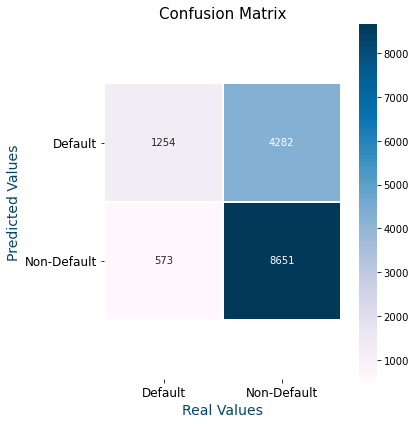

In [90]:
# Checking the confusion matrix.
show_confusion_matrix(y_test, y_pred)

In [91]:
# Checking the metrics.
all_metrics(y_test, y_pred, y_pred_prob)

,Value,Description
"Positive, P",1827.000000,default
"Negative, N",12933.000000,non-default
"True Positive, TP",1254.000000,correctly identified default
"True Negative, TN",8651.000000,correctly identified non-default
"False Positive, FP",4282.000000,incorrectly identified default
"False Negative, FN",573.000000,incorrectly identified non-default
Accuracy,0.671070,Accuracy=(TP+TN)/(P+N)
Precision,0.226517,Precision = TP/(TP+FP)
Recall,0.686371,Recall = TP/P
F1-score,0.340622,Harmonical mean of Precision и Recall


Recall increased from 2 to 68 percent. Unfortunately, the Precision has decreased, because now our algorithm is more likely to detect defaults even where there are none. Harmonic mean between Recall and Precision (F1 Score) also decreased. However, from the point of view of the consumer, i.e. the bank, we can say that the quality of the model has increased. However, there is still enough room for improvement.

# 9. Submission

In [92]:
data_train = data.query('sample == 1').drop(['sample', 'client_id', 'app_date'], axis=1)
data_test = data.query('sample == 0').drop(['sample', 'client_id', 'app_date'], axis=1)

In [93]:
X_train = data_train.drop(['default'], axis=1)
y_train = data_train['default'].values
X_test = data_test.drop(['default'], axis=1)

In [94]:
model = LogisticRegression(random_state=random_seed, 
                           C=1, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l1', 
                           solver='liblinear', 
                           verbose=0, 
                           warm_start=False,
                           max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [95]:
y_pred_prob = model.predict_proba(X_test)[:,1]

In [96]:
submit = pd.DataFrame(data.query('sample == 0')['client_id'])
submit['default'] = y_pred_prob
submit.to_csv('submission3.csv', index=False)